In [5]:
!python3 -m ensurepip --upgrade

Looking in links: /tmp/tmpxvs060qy


In [6]:
!python3 -m pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [7]:
!python3 -m pip install git+https://www.github.com/mouseland/cellpose.git

  Cloning https://www.github.com/mouseland/cellpose.git to /tmp/pip-req-build-d4hxnk3_
  Running command git clone --filter=blob:none --quiet https://www.github.com/mouseland/cellpose.git /tmp/pip-req-build-d4hxnk3_
  Resolved https://www.github.com/mouseland/cellpose.git to commit 17fb25f40055ec2636aa708dc4cf6625b8b4735d
  Preparing metadata (setup.py) ... done


In [19]:
import numpy as np
from skimage.measure import regionprops
from skimage.filters import sobel

def compute_metrics(mask):
    if mask is None or mask.max() == 0:
        return {
            "n_objects": 0,
            "mean_size": 0,
            "var_size": 0,
            "edge_density": 0,
            "score": 0
        }

    labels = mask
    props = regionprops(labels)

    areas = [p.area for p in props]
    if len(areas) == 0:
        return {
            "n_objects": 0,
            "mean_size": 0,
            "var_size": 0,
            "edge_density": 0,
            "score": 0
        }

    edges = sobel(mask > 0)
    edge_density = edges.mean()

    score = (
        len(areas) * 0.2 +
        (np.mean(areas) > 20) * 0.2 + 
        (edge_density > 0.01) * 0.2 +
        (np.var(areas) < (np.mean(areas) * 10)) * 0.2 + 
        (len(areas) < 200) * 0.2
    )

    return {
        "n_objects": len(areas),
        "mean_size": float(np.mean(areas)),
        "var_size": float(np.var(areas)),
        "edge_density": float(edge_density),
        "score": float(score)
    }

In [20]:
diameters = [None, 10, 20, 30, 40, 60, 80]
channels = [[0,0]]

In [22]:
from cellpose import models, io
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

model = models.CellposeModel(gpu=True)

base_dir = Path("content")
image_files = list(base_dir.rglob("*.png"))

diameters = [None, 10, 20, 30, 40, 60, 80]
channels = [[0,0]]

results = []

for img_path in image_files:
    print(f"\n=== {img_path.name} ===")

    img = io.imread(img_path)
    if img.ndim == 3:
        from skimage.color import rgb2gray
        img_gray = rgb2gray(img)
    else:
        img_gray = img

    for diam in diameters:

        out = model.eval(
            img_gray,
            diameter=diam,
            channels=None
        )

        masks = out[0]

        metrics = compute_metrics(masks)

        results.append({
            "image": img_path.name,
            "diameter": diam,
            **metrics
        })

        print(f"diam={diam} → score={metrics['score']:.3f}, "
              f"objects={metrics['n_objects']}")

df = pd.DataFrame(results)
df


=== 154_1.png ===
diam=None → score=16.000, objects=77
diam=10 → score=13.000, objects=63
diam=20 → score=20.400, objects=99
diam=30 → score=16.000, objects=77
diam=40 → score=17.400, objects=84
diam=60 → score=17.600, objects=85
diam=80 → score=15.600, objects=75

=== 157_3.png ===
diam=None → score=3.000, objects=13
diam=10 → score=15.000, objects=72
diam=20 → score=5.800, objects=27
diam=30 → score=3.000, objects=13
diam=40 → score=3.600, objects=16
diam=60 → score=1.000, objects=3
diam=80 → score=1.000, objects=3

=== 170_6.png ===
diam=None → score=13.000, objects=62
diam=10 → score=15.600, objects=75
diam=20 → score=12.800, objects=61
diam=30 → score=13.000, objects=62
diam=40 → score=11.000, objects=52
diam=60 → score=18.200, objects=88
diam=80 → score=19.200, objects=93

=== 160_4.png ===
diam=None → score=18.600, objects=90
diam=10 → score=13.200, objects=63
diam=20 → score=16.600, objects=80
diam=30 → score=18.600, objects=90
diam=40 → score=17.800, objects=86
diam=60 → scor

,image,diameter,n_objects,mean_size,var_size,edge_density,score
0,154_1.png,NaN,77,7362.948052,2.007762e+07,0.018911,16.0
1,154_1.png,10.0,63,1292.936508,6.813068e+05,0.009847,13.0
2,154_1.png,20.0,99,4229.797980,1.067874e+07,0.023402,20.4
3,154_1.png,30.0,77,7362.948052,2.007762e+07,0.018911,16.0
4,154_1.png,40.0,84,7741.130952,2.131750e+07,0.021354,17.4
5,154_1.png,60.0,85,8614.341176,2.634274e+07,0.020074,17.6
6,154_1.png,80.0,75,9787.720000,2.960584e+07,0.019899,15.6
7,157_3.png,NaN,13,5545.230769,1.097992e+07,0.004412,3.0
8,157_3.png,10.0,72,1351.847222,7.804986e+05,0.013166,15.0
9,157_3.png,20.0,27,2473.555556,2.687691e+06,0.006135,5.8


In [23]:
best = df.sort_values("score", ascending=False).groupby("image").first()
best

,diameter,n_objects,mean_size,var_size,edge_density,score
image,,,,,,
153_3.png,20.0,202,2323.747525,1.290684e+06,0.036219,40.8
154_1.png,20.0,99,4229.797980,1.067874e+07,0.023402,20.4
157_3.png,10.0,72,1351.847222,7.804986e+05,0.013166,15.0
160_4.png,60.0,94,4260.638298,1.016971e+07,0.023439,19.4
170_1.png,10.0,22,121.545455,3.850066e+03,0.001155,4.8
170_6.png,80.0,93,6897.892473,1.775976e+07,0.018909,19.2


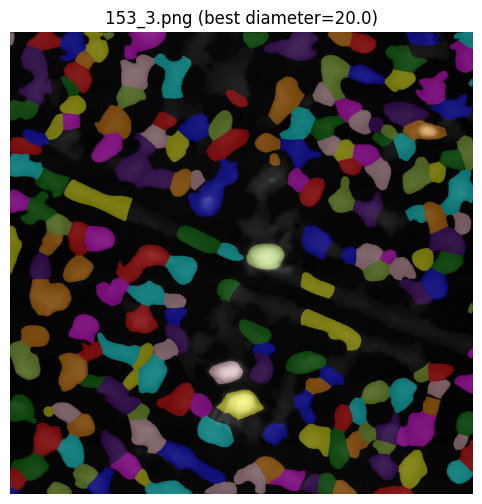

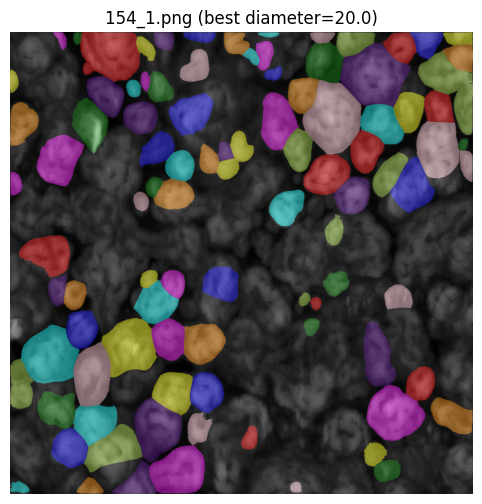

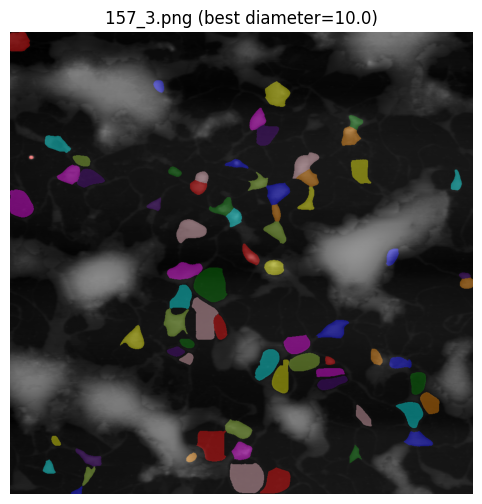

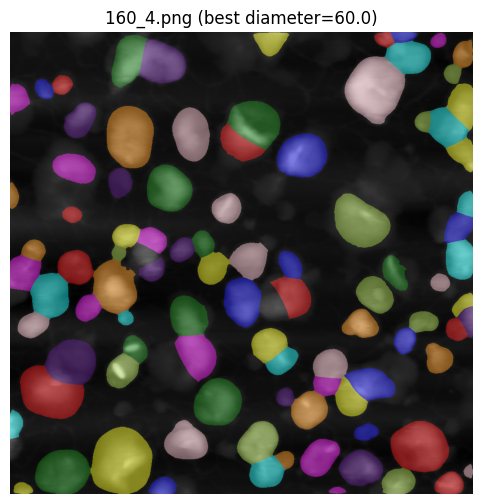

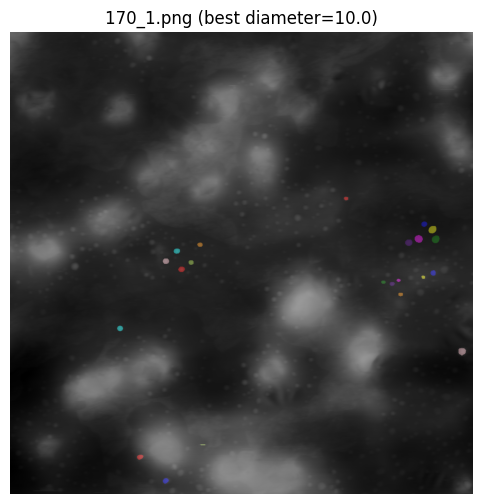

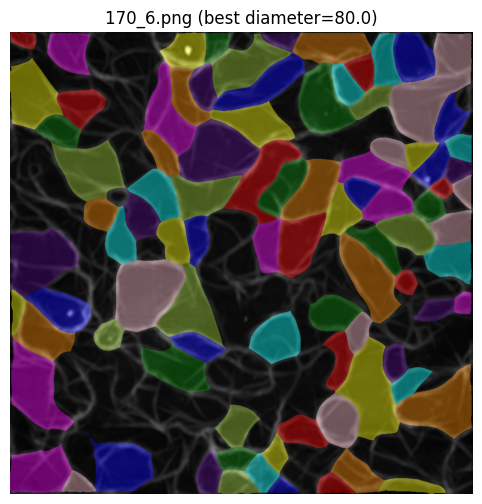

In [25]:
from skimage.color import label2rgb

for img_name, row in best.iterrows():
    img_path = base_dir / img_name
    img = io.imread(img_path)
    if img.ndim == 3:
        from skimage.color import rgb2gray
        img_gray = rgb2gray(img)
    else:
        img_gray = img

    diam = row["diameter"]
    out = model.eval(img_gray, diameter=diam, channels=None)
    masks = out[0]                    # ← mask array (H, W)
    overlay = label2rgb(masks, image=img_gray, alpha=0.4)

    plt.figure(figsize=(12,6))
    plt.title(f"{img_name} (best diameter={diam})")
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()